In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

sns.set_style("whitegrid")

This notebook contains analysis of results of microbenchmarking xios2 and xios3 simple programs using an unstructured grid.

- xios3 version: commit 6b770a30b69c469d1c86385dc561e72a72dd8032
- xios2 version: 2.6.1.0

# Write performance

In [27]:
data= pd.read_csv("time_xios2_xios3.txt",sep=r"\s+")
data

,Time send/recv,Initialise,Finalise,nfields,operation,io_nodes,servers_per_node,client_nodes,xios_version
0,0.006640,0.942362,14.670459,8,write,1,12,8,xios-2
1,0.000639,1.222956,1.284618,1,write,8,8,16,xios-2
2,0.016664,1.059895,2.046742,8,write,8,12,8,xios-3
3,0.026811,0.915955,19.863398,16,write,4,1,8,xios-3
4,0.291915,0.978469,3.484231,16,write,8,12,1,xios-3
...,...,...,...,...,...,...,...,...,...
259,0.011692,0.965749,2.067910,4,write,4,8,8,xios-3
260,0.016043,1.073683,9.050921,8,write,1,12,8,xios-3
261,0.003607,0.902500,1.399635,4,write,8,12,8,xios-2
262,0.440281,0.853162,12.482166,16,write,8,1,1,xios-2


<Axes: xlabel='nfields', ylabel='Initialise'>

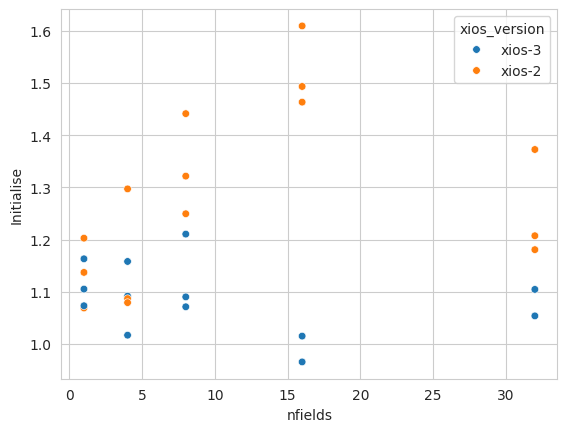

In [28]:
sns.scatterplot(data=data.query("client_nodes==16 & servers_per_node==12 "), y="Initialise", x="nfields", hue="xios_version", s=30)

In [29]:
## Scatterplot
scatter_data = data.pivot(columns="xios_version",index=["nfields","io_nodes","client_nodes","servers_per_node"],values=["Time send/recv","Initialise","Finalise"])\
                .reset_index().dropna()
scatter_data


nfields io_nodes client_nodes servers_per_node Time send/recv  \
xios_version                                                        xios-2   
0                  1        1            1                1       0.008130   
1                  1        1            1                8       0.020411   
2                  1        1            1               12       0.010993   
3                  1        1            8                1       0.096652   
4                  1        1            8                8       0.001180   
..               ...      ...          ...              ...            ...   
128               32        8            1               12       0.968012   
129               32        8            8                1       0.573696   
130               32        8            8                8       0.096548   
132               32        8           16                1       0.843733   
133               32        8           16                8       0.135625   

                       Initialise             Finalise            
xios_version    xios-3     xios-2    xios-3     xios-2    xios-3  
0             0.014640   0.992682  0.861981  34.119719  3.052116  
1             0.011147   0.847147  0.915443   6.893430  2.815978  
2             0.021430   0.767417  0.928233   4.922774  2.056794  
3             0.003282   1.490661  0.980374  40.563620  4.075388  
4             0.007502   0.992785  1.087014   8.124173  2.058085  
..                 ...        ...       ...        ...       ...  
128           0.561076   0.910031  0.988250   5.487325  5.190052  
129           0.047215   0.993425  0.924486  22.097449  9.082379  
130           0.048109   0.916097  1.049384   6.726881  5.795682  
132           0.025044   1.038325  1.298131  21.870126  9.148219  
133           0.030309   1.396318  1.118149   6.375516  6.058605  

[129 rows x 10 columns]

In [30]:
def scatter_plot(scatter_data, time_column,ax=None):
    data = pd.DataFrame({
        "xios-2": scatter_data[time_column]["xios-2"],
        "xios-3": scatter_data[time_column]["xios-3"],
        "relative_performance": (1./scatter_data[time_column]["xios-3"] - 1./scatter_data[time_column]["xios-2"])*scatter_data[time_column]["xios-2"]
    })

    data["cmap"] = data["relative_performance"].apply(lambda x: 1.0 if x > 0 else 0)   
    
    diag=np.linspace(data["xios-3"].min(), data["xios-3"].max())
    ax.plot(diag, diag, color="black", linestyle="--")
    cmap = sns.color_palette("RdYlGn",n_colors=2)
    
    sns.scatterplot(data=data,x="xios-2", y="xios-3",hue="cmap", s=100,legend=None,palette=cmap, ax=ax)
    ax.set_xlabel(f" {time_column} xios-2 (s)")
    ax.set_ylabel(f" {time_column} xios-3 (s)")


## Averall comparison between xios2 and xios3

Below we show an overview of the difference in performance between xios2 and xios3.
We plot the correlation between time spent in xios2 and xios3 , in each of the three main phases:
- `Initialisation`: Time spent in the context closure on the clients.
- `Send/Recv`: Time spent sending data to the servers. If there is no back-pressure from the servers, refusing payloads from running out of memory , this should be equal to the time spent in sending data to the servers plus any data processing being executed on the clients
- `Finalise`: Time spent in context finalisation. This is the call is dominated from servers being busy processing incoming data. Most of the time spent in I/O \
            to the disk on the servers is captured here.

Each field is distributed on an uniform grid of shape `[70,896,896,6]` . The process grid is chosen as `[1,X,Y,6]` where X and Y are chosen such as X*Y = total number of ranks. This mimics the data layout used on lfric, where 6 corresponds the 6 different panels and 70 is the number of layers of the operational configuration.

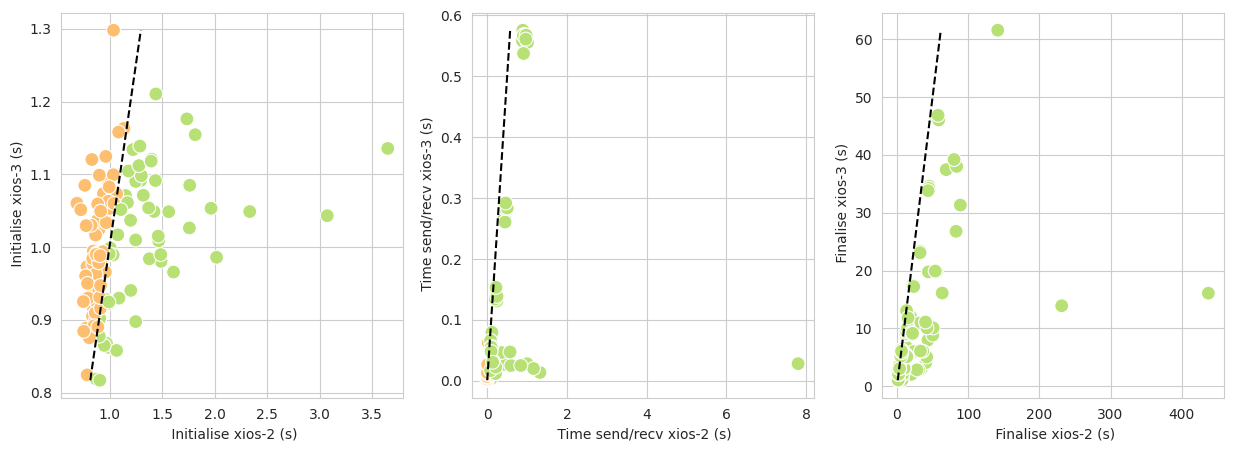

In [7]:
fig, axs = plt.subplots(1, 3 ,figsize=(15, 5))
scatter_plot(scatter_data, "Initialise",ax=axs[0])
scatter_plot(scatter_data, "Time send/recv",ax=axs[1])
scatter_plot(scatter_data, "Finalise",ax=axs[2])

Green points indicate that xios-3 is faster, while orange points indicate that xios-2 is faster. The dashed line indicates equal times in xios2 and xios3.
xios2 seems to have a bigger tail of runs which are slow to initialise. Jobs with a higher initialisation times seem faster in xios2. At smaller initialisation times, it seems xios2 has slightly smaller overheads. Latency of send/recv seems greatly reduced in xios3 compared to xios2. The time spent in finalisation dominates the run time. The points where xios2 initialisation time is smaller are mostly at lower number of node clients. At larger node counts, xios3 initialisation time appears to be smaller or consistent within noise.

## I-O bandwidth

In [8]:
# Read darshan profile data
data=pd.read_csv("io_xio2_xios3.txt",sep=r"\s+")
data

,layer,operation,rank,value,filename,nfields,io_nodes,servers_per_node,client_nodes,xios_version
0,POSIX,POSIX_F_READ_TIME,2304,0.000199,/work/z19/shared/lparisi/xios-benchmark/result...,8,1,12,8,xios-2
1,POSIX,POSIX_F_WRITE_TIME,2304,7.139217,/work/z19/shared/lparisi/xios-benchmark/result...,8,1,12,8,xios-2
2,POSIX,POSIX_F_META_TIME,2304,0.002333,/work/z19/shared/lparisi/xios-benchmark/result...,8,1,12,8,xios-2
3,POSIX,POSIX_F_MAX_READ_TIME,2304,0.000036,/work/z19/shared/lparisi/xios-benchmark/result...,8,1,12,8,xios-2
4,POSIX,POSIX_F_MAX_WRITE_TIME,2304,0.005101,/work/z19/shared/lparisi/xios-benchmark/result...,8,1,12,8,xios-2
...,...,...,...,...,...,...,...,...,...,...
1440054,H5D,H5D_F_MAX_READ_TIME,295,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,32,8,1,1,xios-3
1440055,H5D,H5D_F_MAX_WRITE_TIME,295,0.150984,/work/z19/shared/lparisi/xios-benchmark/result...,32,8,1,1,xios-3
1440056,H5D,H5D_F_FASTEST_RANK_TIME,295,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,32,8,1,1,xios-3
1440057,H5D,H5D_F_SLOWEST_RANK_TIME,295,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,32,8,1,1,xios-3


In [9]:
# Select only metrics of interest and take the maximum time across all ranks, as the slowest rank determines the overall I/O performance
filtered_data=data[data["operation"].isin(["H5D_F_WRITE_TIME","MPIIO_F_WRITE_TIME","POSIX_F_WRITE_TIME"]) ]
filtered_data=filtered_data.drop(columns=["layer","filename","rank"])\
    .groupby(["nfields","io_nodes","client_nodes","servers_per_node","xios_version","operation"])\
    .aggregate("max").reset_index()
filtered_data

,nfields,io_nodes,client_nodes,servers_per_node,xios_version,operation,value
0,1,1,1,1,xios-2,H5D_F_WRITE_TIME,0.593271
1,1,1,1,1,xios-2,POSIX_F_WRITE_TIME,0.594158
2,1,1,1,1,xios-3,H5D_F_WRITE_TIME,0.677326
3,1,1,1,1,xios-3,POSIX_F_WRITE_TIME,0.609516
4,1,1,1,8,xios-2,H5D_F_WRITE_TIME,1.279072
...,...,...,...,...,...,...,...
760,32,8,16,8,xios-3,MPIIO_F_WRITE_TIME,4.457778
761,32,8,16,8,xios-3,POSIX_F_WRITE_TIME,3.341249
762,32,8,16,12,xios-2,H5D_F_WRITE_TIME,0.144485
763,32,8,16,12,xios-2,MPIIO_F_WRITE_TIME,4.018099


In [10]:
# Pivot the data to make it suitable for scatter plotting, with separate columns for each xios version and operation
scatter_data=filtered_data.pivot(columns=["operation","xios_version"],index=["nfields","io_nodes","client_nodes","servers_per_node"],values="value").reset_index().dropna()
scatter_data

operation    nfields io_nodes client_nodes servers_per_node H5D_F_WRITE_TIME  \
xios_version                                                          xios-2   
1                  1        1            1                8         1.279072   
2                  1        1            1               12         1.157136   
4                  1        1            8                8         1.300420   
5                  1        1            8               12         0.947741   
7                  1        1           16                8         1.263346   
..               ...      ...          ...              ...              ...   
128               32        8            1               12         0.463515   
129               32        8            8                1         0.138388   
130               32        8            8                8         0.157750   
132               32        8           16                1         0.148207   
133               32        8           16                8         0.146662   

operation    POSIX_F_WRITE_TIME H5D_F_WRITE_TIME POSIX_F_WRITE_TIME  \
xios_version             xios-2           xios-3             xios-3   
1                      1.335996         1.258491           1.239738   
2                      1.138113         0.933325           0.961592   
4                      1.263129         1.260822           1.250270   
5                      0.933099         0.920295           0.911439   
7                      1.283993         1.226449           1.225274   
..                          ...              ...                ...   
128                    3.096836         0.144098           3.210550   
129                    2.984531         0.157012           3.132011   
130                    3.093365         0.140268           3.384680   
132                    3.088116         0.147523           3.138012   
133                    3.085217         0.148509           3.341249   

operation    MPIIO_F_WRITE_TIME            
xios_version             xios-2    xios-3  
1                      1.395334  1.329203  
2                      1.180904  1.018599  
4                      1.320345  1.334059  
5                      0.973785  0.972577  
7                      1.338153  1.305187  
..                          ...       ...  
128                    5.073351  4.272170  
129                    4.140300  4.429680  
130                    4.229393  4.262037  
132                    4.285095  4.356537  
133                    4.070572  4.457778  

[117 rows x 10 columns]

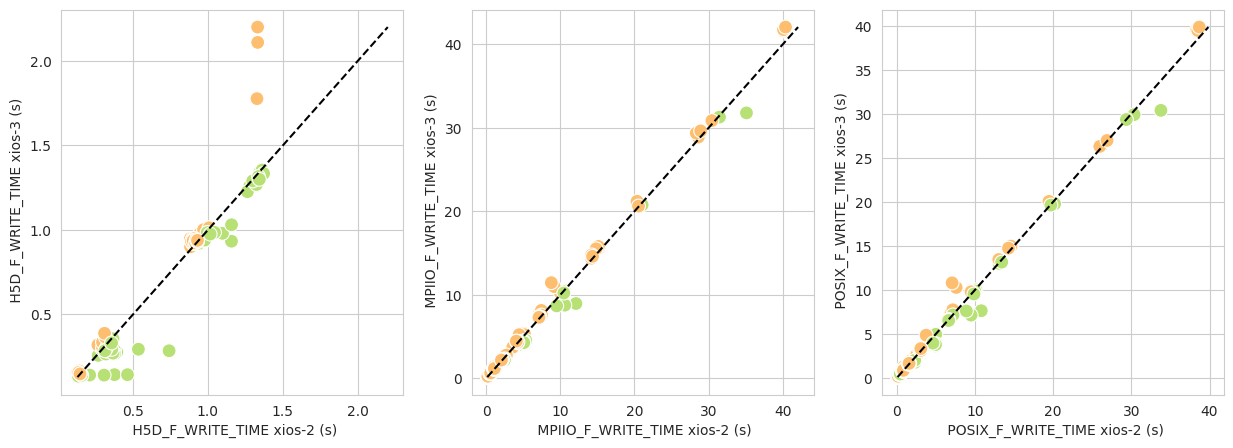

In [11]:
# Plot the time spent in HDF5, MPI-IO and POSIX write operations for xios-2 vs xios-3
fig, axs = plt.subplots(1, 3 ,figsize=(15, 5))
scatter_plot(scatter_data, "H5D_F_WRITE_TIME",ax=axs[0])
scatter_plot(scatter_data, "MPIIO_F_WRITE_TIME",ax=axs[1])
scatter_plot(scatter_data, "POSIX_F_WRITE_TIME",ax=axs[2])


# Read performance

In [12]:
data=pd.read_csv("timers_read.txt",sep=r"\s+")
data=data.query("operation == 'read'")
data

,Time send/recv,Initialise,Finalise,nfields,operation,io_nodes,servers_per_node,client_nodes,xios_version
0,1.358864,1.345012,0.761675,4,read,4,8,16,xios-3
1,26.663226,1.994902,0.016697,32,read,1,8,1,xios-2
3,1.157737,1.194014,0.900936,1,read,1,8,8,xios-3
5,9.711713,1.330114,0.416130,32,read,4,8,16,xios-3
7,2.842358,1.074800,0.932341,1,read,1,1,1,xios-3
...,...,...,...,...,...,...,...,...,...
779,5.122186,1.244165,0.848668,8,read,4,1,8,xios-3
780,6.071939,0.933393,0.010164,1,read,1,8,1,xios-2
786,5.460929,1.327894,0.657755,8,read,1,8,16,xios-3
790,2.923877,1.028349,0.867707,4,read,1,8,1,xios-3


<Axes: xlabel='nfields', ylabel='Initialise'>

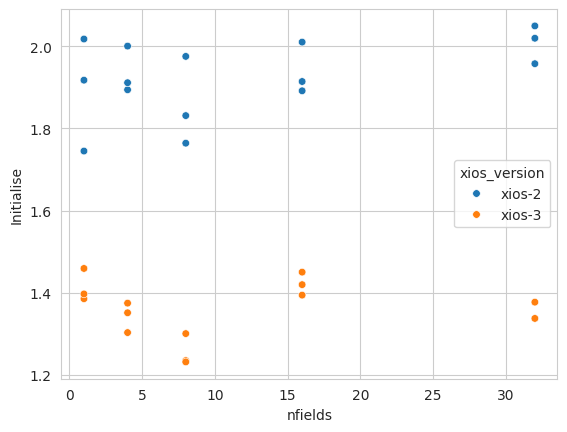

In [13]:
sns.scatterplot(data=data.query("client_nodes==16 & servers_per_node==12 "), y="Initialise", x="nfields", hue="xios_version", s=30)

In [14]:
## Scatterplot
scatter_data = data.pivot(columns="xios_version",index=["nfields","io_nodes","client_nodes","servers_per_node"],values=["Time send/recv","Initialise","Finalise"])\
                .reset_index().dropna()
scatter_data

nfields io_nodes client_nodes servers_per_node Time send/recv  \
xios_version                                                        xios-2   
0                  1        1            1                1      33.732205   
1                  1        1            1                8       6.071939   
2                  1        1            1               12       4.218678   
3                  1        1            8                1      40.339789   
4                  1        1            8                8       7.374407   
..               ...      ...          ...              ...            ...   
129               32        8            8                1      21.834612   
130               32        8            8                8       7.425227   
131               32        8            8               12       6.881258   
132               32        8           16                1      22.873184   
133               32        8           16                8       7.410035   

                        Initialise            Finalise            
xios_version     xios-3     xios-2    xios-3    xios-2    xios-3  
0              2.842358   1.294639  1.074800  0.038792  0.932341  
1              1.099980   0.933393  0.978673  0.010164  0.953290  
2              0.953956   0.896011  1.045807  0.017214  1.122268  
3              4.741966   1.615507  1.129783  0.145876  1.056986  
4              1.157737   1.097032  1.194014  0.106441  0.900936  
..                  ...        ...       ...       ...       ...  
129           11.269559   1.292616  1.178734  0.037424  0.795386  
130            7.697368   1.109554  1.196899  0.023429  0.369699  
131            7.438851   1.139520  1.191554  0.026813  0.636477  
132           11.348747   2.834763  1.652069  0.183497  0.779369  
133            7.534804   1.844086  1.389087  0.027720  0.558865  

[134 rows x 10 columns]

/tmp/ipykernel_2662496/2048242077.py:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=data,x="xios-2", y="xios-3",hue="cmap", s=100,legend=None,palette=cmap, ax=ax)


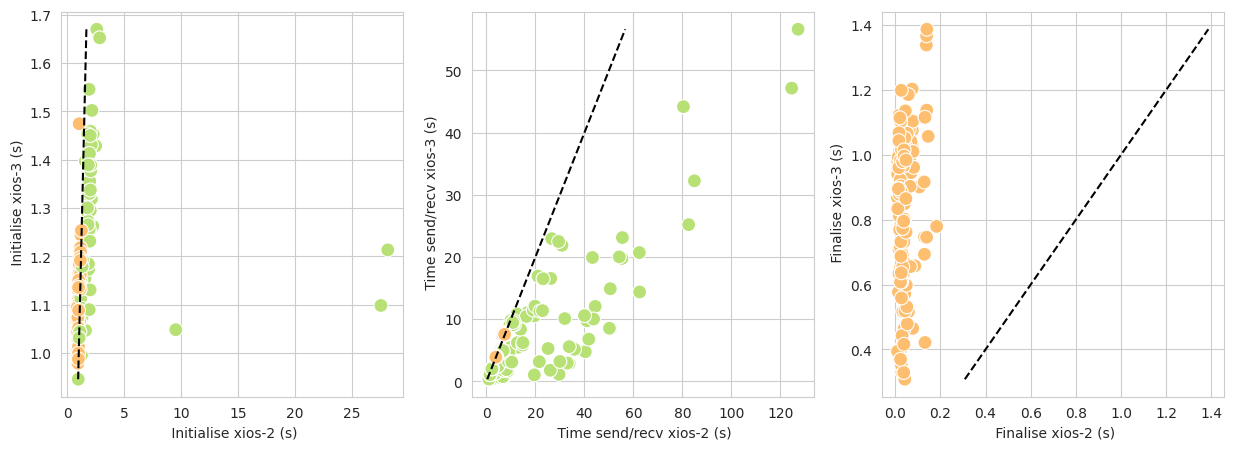

In [15]:
fig, axs = plt.subplots(1, 3 ,figsize=(15, 5))
scatter_plot(scatter_data, "Initialise",ax=axs[0])
scatter_plot(scatter_data, "Time send/recv",ax=axs[1])
scatter_plot(scatter_data, "Finalise",ax=axs[2])

## I/O read performance 

In [31]:
# Read darshan profile data
data=pd.read_csv("io_report_read.txt",sep=r"\s+")
data

,layer,operation,rank,value,filename,nfields,io_nodes,servers_per_node,client_nodes,xios_version
0,MPI-IO,MPIIO_F_READ_TIME,4608,1.142437,/work/z19/shared/lparisi/xios-benchmark/result...,4,4,8,16,xios-3
1,MPI-IO,MPIIO_F_WRITE_TIME,4608,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,4,4,8,16,xios-3
2,MPI-IO,MPIIO_F_META_TIME,4608,0.014086,/work/z19/shared/lparisi/xios-benchmark/result...,4,4,8,16,xios-3
3,MPI-IO,MPIIO_F_MAX_READ_TIME,4608,0.367333,/work/z19/shared/lparisi/xios-benchmark/result...,4,4,8,16,xios-3
4,MPI-IO,MPIIO_F_MAX_WRITE_TIME,4608,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,4,4,8,16,xios-3
...,...,...,...,...,...,...,...,...,...,...
6439554,H5D,H5D_F_MAX_READ_TIME,4655,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,1,4,12,16,xios-3
6439555,H5D,H5D_F_MAX_WRITE_TIME,4655,0.294213,/work/z19/shared/lparisi/xios-benchmark/result...,1,4,12,16,xios-3
6439556,H5D,H5D_F_FASTEST_RANK_TIME,4655,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,1,4,12,16,xios-3
6439557,H5D,H5D_F_SLOWEST_RANK_TIME,4655,0.000000,/work/z19/shared/lparisi/xios-benchmark/result...,1,4,12,16,xios-3


In [32]:
# Select only metrics of interest and take the maximum time across all ranks, as the slowest rank determines the overall I/O performance
filtered_data=data[data["operation"].isin(["H5D_F_READ_TIME","MPIIO_F_READ_TIME","POSIX_F_READ_TIME"]) ]
filtered_data=filtered_data.drop(columns=["layer","filename","rank"])\
    .groupby(["nfields","io_nodes","client_nodes","servers_per_node","xios_version","operation"])\
    .aggregate("max").reset_index()
filtered_data

,nfields,io_nodes,client_nodes,servers_per_node,xios_version,operation,value
0,1,1,1,1,xios-2,H5D_F_READ_TIME,0.000000
1,1,1,1,1,xios-2,POSIX_F_READ_TIME,0.000000
2,1,1,1,1,xios-3,H5D_F_READ_TIME,0.000000
3,1,1,1,1,xios-3,POSIX_F_READ_TIME,0.000000
4,1,1,1,8,xios-2,H5D_F_READ_TIME,0.000000
...,...,...,...,...,...,...,...
771,32,8,16,12,xios-2,MPIIO_F_READ_TIME,5.110972
772,32,8,16,12,xios-2,POSIX_F_READ_TIME,0.000181
773,32,8,16,12,xios-3,H5D_F_READ_TIME,0.000000
774,32,8,16,12,xios-3,MPIIO_F_READ_TIME,0.000000


In [33]:
# Pivot the data to make it suitable for scatter plotting, with separate columns for each xios version and operation
scatter_data=filtered_data.pivot(columns=["operation","xios_version"],index=["nfields","io_nodes","client_nodes","servers_per_node"],values="value").reset_index().dropna()
scatter_data

operation    nfields io_nodes client_nodes servers_per_node H5D_F_READ_TIME  \
xios_version                                                         xios-2   
1                  1        1            1                8             0.0   
2                  1        1            1               12             0.0   
4                  1        1            8                8             0.0   
5                  1        1            8               12             0.0   
7                  1        1           16                8             0.0   
..               ...      ...          ...              ...             ...   
130               32        8            8                8             0.0   
131               32        8            8               12             0.0   
132               32        8           16                1             0.0   
133               32        8           16                8             0.0   
134               32        8           16               12             0.0   

operation    POSIX_F_READ_TIME H5D_F_READ_TIME POSIX_F_READ_TIME  \
xios_version            xios-2          xios-3            xios-3   
1                     0.000160             0.0          0.000104   
2                     0.000179             0.0          0.000106   
4                     0.000182             0.0          0.000105   
5                     0.000175             0.0          0.000110   
7                     0.000159             0.0          0.000103   
..                         ...             ...               ...   
130                   0.000190             0.0          0.000102   
131                   0.000194             0.0          0.000097   
132                   0.000178             0.0          0.000105   
133                   0.000196             0.0          0.000106   
134                   0.000181             0.0          0.000110   

operation    MPIIO_F_READ_TIME            
xios_version            xios-2    xios-3  
1                     0.529969  0.608068  
2                     0.417646  0.600193  
4                     0.522971  0.595389  
5                     0.379913  0.571169  
7                     0.610231  0.591800  
..                         ...       ...  
130                   5.087043  6.930632  
131                   5.118502  6.823306  
132                   5.653179  7.755185  
133                   5.140674  6.827950  
134                   5.110972  0.000000  

[119 rows x 10 columns]

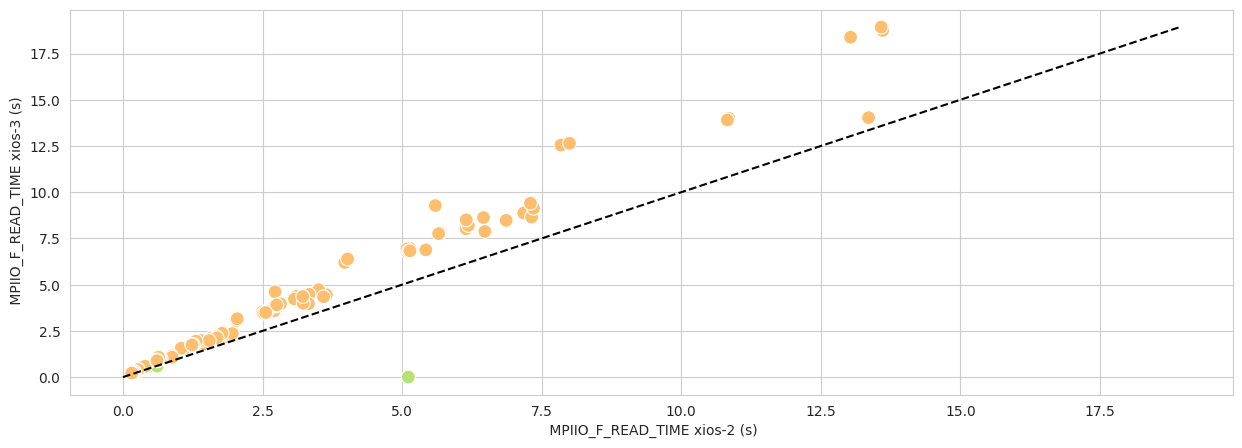

In [42]:
# Plot the time spent in HDF5, MPI-IO and POSIX write operations for xios-2 vs xios-3
fig, axs = plt.subplots(1, 1 ,figsize=(15, 5))
scatter_plot(scatter_data, "MPIIO_F_READ_TIME",ax=axs)

Read performance is overall lower at all at all scales. The time in read is dominated by communication costs in mpiio in both xios3 and xios3. The loss in read performance is balanced from lower xios overeheads, so overall performance is higher overall. The time in POSIX calls seems to be very low overall 